In [1]:
import numpy as np
import pandas as pd
import os
import os.path
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
import joblib
from rdkit import Chem
from rdkit.Chem import Draw

In [4]:
mols = []
mols_name = []
# mols_train = []

key = open('key.txt','r')
a = key.read()
bit_info = eval(a)
key.close()

def get_labels():
    df = pd.read_excel('./molecules.xlsx')
    labels = []
    labels.append(pd.DataFrame(df['光热转换效率（%）']))
    labels[0].dropna(axis=0, how='any', inplace=True)
    labels[0].reset_index(drop=True, inplace=True)
    # labels = ms_labels.fit_transform(labels[0])
    labels = np.array(labels[0])
    labels = np.array(labels).ravel()
    return df,labels

def get_fea():
    descriptors = pd.read_csv('descriptors.csv')
    circular_fingerprint = np.array(pd.read_csv('circular_fingerprint.csv'))
    Daylight_fingerprint = np.array(pd.read_csv('Daylight_fingerprint.csv'))
    atompair_fingerprint = np.array(pd.read_csv('atompair_fingerprint.csv'))
    return descriptors,circular_fingerprint,Daylight_fingerprint,atompair_fingerprint

def r2_display(train_pred,train_ture,pred,ture,great_train_score,great_score,fea_type,al):
    # fig, ax = plt.subplots(1, 1, num="stars", figsize=(13, 12))
    # Axis_line = np.linspace(*ax.get_xlim(), 2)
    # ax.plot(Axis_line, Axis_line, transform=ax.transAxes, linestyle='--', linewidth=2, color='black', label="1:1 Line")

    fig, ax = plt.subplots(figsize = (5,5))
    ax.plot((0, 1), (0, 1),transform=ax.transAxes, ls='--', c='k')
    ax.set_title('R² score',fontsize=12.5)
    ax.set_xlabel('Experimental photothermal conversion efficiency',fontsize=12.5)
    ax.set_ylabel('Predicted photothermal conversion efficiency',fontsize=12.5)
    ax.scatter(ture, pred, c='blue', label=('Test R²=%f' %great_score), alpha=0.5)
    ax.scatter(train_ture, train_pred, c='red', label=('Train R²=%f' %great_train_score), alpha=0.5)
    ax.legend(loc=4,fontsize = 12.5)
    ax.figure.savefig("%s+%s2.png" %(fea_type,al), dpi=800, bbox_inches='tight')

df,labels = get_labels()
descriptors,circular_fingerprint,Daylight_fingerprint,atompair_fingerprint = get_fea()

In [7]:
def rf(X, y,rand,fea_type):
    from sklearn.model_selection import KFold
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(random_state=rand) #at 1
    model.fit(X,y)
    model = SelectFromModel(model, prefit=True)
    X = model.transform(X)
    # cir_selected_name.append(pd.read_csv('circular_fingerprint.csv').columns[model.get_support()])
    # pdX = pd.DataFrame(X)
    # pdX.columns = cir_selected_name[0].values
    # pdX.to_csv(os.path.join('./', 'circular_fingerprint_selected.csv'), index=False)
    model2 = RandomForestRegressor()
    great_score = 0
    great_train_score = 0
    for i in np.arange(1,2,1):
        for j in np.arange(1,2,1):
            if fea_type == 'circular_fingerprint' :
                grid_params = {
                                'n_estimators': [2], # 6
                                'max_features' : [5], # 3
                                }
            if fea_type == 'Daylight_fingerprint' :
                grid_params = {
                                'n_estimators': [4],
                            'max_features': [2],
                            }
            if fea_type == 'Atompair_fingerprint':
                grid_params = {
                    'n_estimators': [3], #38
                    'max_features': [2], #10
                }
            if fea_type == 'Descriptors':
                grid_params = {
                    'n_estimators': [1], #38 3
                    'max_features': [15], #10 23
                }
            model_cv = GridSearchCV(model2, grid_params, cv=6, verbose=1, n_jobs=-1,scoring='r2')
            score_train_ = []
            score_test_ = []
            # MAE = []
            # R2 = []
            pred_list = []
            ture_list = []
            pred_trian_list = []
            ture_train_list = []
            pearson_list = []
            RMSE_list = []
            kf = KFold(n_splits=5,shuffle=True, random_state=35) #12 0.3
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model_cv.fit(X_train, y_train)
                method_ = RandomForestRegressor(
                    n_estimators=model_cv.best_params_['n_estimators'],
                    max_features=model_cv.best_params_['max_features'],
                    random_state=rand
                )
                method_fp = method_.fit(X_train, y_train)
                pred_train = method_fp.predict(X_train)
                pred = method_fp.predict(X_test)
                score_train = method_fp.score(X_train, y_train)
                score_test = method_fp.score(X_test, y_test)

                score_train_.append(score_train)
                score_test_.append(score_test)
                pred_list.append(pred)
                ture_list.append(y_test)
                pred_trian_list.append(pred_train)
                ture_train_list.append(y_train)
                pearson_list.append(np.corrcoef(pred,y_test))
                RMSE_list.append(np.sqrt(mean_squared_error(pred,y_test)))

                # auc.append(roc_auc_score(pd.DataFrame(y_test), pd.DataFrame(pred_proba),multi_class='ovr'))
            if np.max(score_test_) >= great_score:
                mols_train = list(np.array(mols)[train_index])
                bit_info_train = list(np.array(bit_info)[train_index])
                mols_name_train = list(np.array(mols_name)[train_index])
                # cir_selected_name.append(pd.read_csv('circular_fingerprint.csv').columns[model.get_support()])
                # pdX = pd.DataFrame(X_train)
                # pdX.columns = cir_selected_name[0].values
                # pdX.to_csv(os.path.join('./', 'circular_fingerprint_selected.csv'), index=False)
                # selector = SelectFromModel(method_fp, prefit=True)
                # index = np.argmax(score_test_)
                # nmb.append(rand)
                # great_train_score = score_train_[index]
                # great_score = score_test_[index]
                # nmb.append(i)
                # nmb.append(j)
                # nmb.append(score_train_[index])
                # nmb.append(score_test_[index])
                # pearson.append(pearson_list[index])
                # RMSE.append(RMSE_list[index])
                # r2_display(pred_trian_list[index],ture_train_list[index],pred_list[index],ture_list[index],great_train_score,great_score,fea_type,'rf')
                # joblib.dump(filename='RF_cir.model', value=method_fp)
    # print(great_train_score)
    # print(great_score)
    return mols_train,bit_info_train,mols_name_train

def svm(X, y,rand,fea_type):
    from sklearn.model_selection import KFold
    from sklearn.svm import SVR
    model = SVR(kernel= 'linear') #at 1
    model.fit(X,y)
    model = SelectFromModel(model, prefit=True)
    X = model.transform(X)
    # ffff = pd.read_csv('descriptors_name.csv')
    # des_selected_name.append(pd.read_csv('descriptors.csv').columns[model.get_support()])
    # pdX = pd.DataFrame(X)
    # pdX.columns = des_selected_name[0].values
    # pdX.to_csv(os.path.join('./', 'descriptors_name_selected.csv'), index=False)
    model2 = SVR(
        kernel= 'linear',
    )
    great_score = 0
    great_train_score = 0
    for i in np.arange(1,2,1):
        for j in np.arange(1,2,1):
            for k in np.arange(1,2,1):
            # for k in np.arange(1,10,1):
            #     for o in np.arange(1,10,1):
                if fea_type == 'circular_fingerprint':
                    grid_params = {'C': [3] , #2
                                # 'gamma': [0.006],
                                'epsilon' :[8.9],#0.08
                                'tol' : [9] # 1.7
                                }
                if fea_type == 'Daylight_fingerprint':
                    grid_params = {'C': [0.7] ,
                                # 'gamma': [0.009],
                                'epsilon' :[0.4],
                                'tol' : [6.7]
                                }
                if fea_type == 'Atompair_fingerprint':
                    grid_params = {'C': [1.6],
                                # 'gamma': [0.002],
                                'epsilon': [0.1],
                                'tol': [0.79]
                                }
                if fea_type == 'Descriptors':
                    grid_params = {'C': [1],
                                # 'gamma': [0.009],
                                'epsilon': [0.13],
                                'tol': [0.89]
                                }
                    # grid_params = {'C': [i] , 'gamma': [0.043], 'epsilon' :[0.042]}  #525 278 239 0.012 0.013 0.011 4.2 0.0001 0
                # grid_params = {'C': np.linspace(0.1,20,50), 'gamma':np.linspace(0.1,20,20)}
                model_cv = GridSearchCV(model2, grid_params, cv=6, verbose=1, n_jobs=2,scoring='r2')
                score_train_ = []
                score_test_ = []
                pred_list = []
                ture_list = []
                pred_trian_list = []
                ture_train_list = []
                pearson_list = []
                RMSE_list = []
                kf = KFold(n_splits=5, shuffle=True, random_state= rand)
                for train_index, test_index in kf.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    model_cv.fit(X_train, y_train)
                    method_ = SVR(kernel= 'linear',
                                C=model_cv.best_params_['C'],
                                # gamma=model_cv.best_params_['gamma'],
                                epsilon=model_cv.best_params_['epsilon'],
                                tol = model_cv.best_params_['tol']
                                )

                    # method_ = SVR(C=model_cv.best_params_['C'],gamma=model_cv.best_params_['gamma'],epsilon=model_cv.best_params_['epsilon'],tol = model_cv.best_params_[tol])
                    method_fp = method_.fit(X_train, y_train)
                    score_train = method_fp.score(X_train, y_train)
                    score_test = method_fp.score(X_test, y_test)
                    pred_train = method_fp.predict(X_train)
                    pred = method_fp.predict(X_test)

                    score_train_.append(score_train)
                    score_test_.append(score_test)
                    pred_list.append(pred)
                    ture_list.append(y_test)
                    pred_trian_list.append(pred_train)
                    ture_train_list.append(y_train)
                    pearson_list.append(np.corrcoef(pred,y_test))
                    RMSE_list.append(np.sqrt(mean_squared_error(pred,y_test)))
                if  np.max(score_test_) >= great_score:
                    # selector = SelectFromModel(method_fp, prefit=True)
                    index = np.argmax(score_test_)
                    great_train_score = score_train_[index]
                    great_score = score_test_[index]
                    r2_display(pred_trian_list[index], ture_train_list[index], pred_list[index], ture_list[index],great_train_score, great_score,fea_type,'svm')
                    # print(score_train_)
                    # print(score_test_)
                    # print(best_para_i)
                    # great_ex = ex
                    # joblib.dump(filename='svm_des.model', value=method_fp)
                    # nmb.append(rand)
                    nmb.append(i)
                    nmb.append(j)
                    # nmb.append(k)
                    nmb.append(score_train_[index])
                    nmb.append(score_test_[index])
                    pearson.append(pearson_list[index])
                    RMSE.append(RMSE_list[index])
                    # nmb.append(k)
                    # nmb.append(o)

    print(great_train_score)
    # print(best_para_i)
    # print(best_para_j)
    # print(best_para_k)
    print(great_score)
    return method_fp

def catb(X, y,rand,fea_type):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True,random_state=35)
    import catboost as cb
    model = cb.CatBoostRegressor(random_state=rand)
    model.fit(X,y)
    model = SelectFromModel(model, prefit=True)
    X = model.transform(X)
    model2 = cb.CatBoostRegressor()
    # grid_params = {'learning_rate': list((0.05,1)), 'iterations': list((50,100)),'depth':list((3,6))}
    great_score = 0
    his_score =[]
    for i in np.arange(1,2,1):
        # for j in np.arange(0.1,1,0.1):
    # for i in np.arange(1,20,1):
        if fea_type == 'circular_fingerprint' :
            grid_params = {'iterations': [17], #17 21
                        'learning_rate' : [0.68], #0.68 0.56
                        'l2_leaf_reg': [1.4], #1.4 1.2
                        'depth': [6] #6
                        }
        if fea_type == 'Daylight_fingerprint' :
            grid_params = {'iterations': [39], # 39
                        'learning_rate' : [0.69], # 0.69
                        'l2_leaf_reg': [0.7], # 0.7
                        'depth': [3], #  3
                        }
        if fea_type == 'Atompair_fingerprint':
            grid_params = {'iterations': [3], #13
                        'learning_rate': [1.5], #0.71
                        'l2_leaf_reg': [1], #2.7
                        'depth': [9] #3
                        }
        if fea_type == 'Descriptors':
            grid_params = {'iterations': [4],
                        'learning_rate': [1.9],
                        'l2_leaf_reg': [2.6],
                           'depth': [6]
                        }
        #7 0.71 2.9 5 ,'learning_rate' : [0.1399],'l2_leaf_reg' : [2.9],'depth' : [6]}
        model_cv = GridSearchCV(model2, grid_params, cv=6, verbose=1, n_jobs=-1,scoring='r2')
        score_train_ = []
        score_test_ = []
        pred_list = []
        ture_list = []
        pred_trian_list = []
        ture_train_list = []
        pearson_list = []
        RMSE_list = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model_cv.fit(X_train, y_train)
            method_ = cb.CatBoostRegressor(iterations=model_cv.best_params_['iterations'],
                                        learning_rate = model_cv.best_params_['learning_rate'],
                                           l2_leaf_reg = model_cv.best_params_['l2_leaf_reg'],
                                           depth = model_cv.best_params_['depth'],
                                        # bagging_temperature = model_cv.best_params_['bagging_temperature'],
                                        loss_function='RMSE',
                                        eval_metric = 'R2',
                                        random_state=rand)
            method_fp = method_.fit(X_train, y_train)
            score_train = method_fp.score(X_train, y_train)
            score_test = method_fp.score(X_test, y_test)
            pred_train = method_fp.predict(X_train)
            pred = method_fp.predict(X_test)

            score_train_.append(score_train)
            score_test_.append(score_test)
            pred_list.append(pred)
            ture_list.append(y_test)
            pred_trian_list.append(pred_train)
            ture_train_list.append(y_train)
            pearson_list.append(np.corrcoef(pred,y_test))
            RMSE_list.append(np.sqrt(mean_squared_error(pred,y_test)))
        if np.max(score_test_) >= great_score:
            # selector = SelectFromModel(method_fp, prefit=True)
            index = np.argmax(score_test_)
            great_score = score_test_[index]
            great_train_score = score_train_[index]
            nmb.append(rand)
            nmb.append(i)
            great_train_score = score_train_[index]
            great_score = score_test_[index]
            # nmb.append(j)
            nmb.append(score_train_[index])
            nmb.append(score_test_[index])
            pearson.append(pearson_list[index])
            RMSE.append(RMSE_list[index])
            # print(great_train_score)
            # print(great_score)
            r2_display(pred_trian_list[index], ture_train_list[index], pred_list[index], ture_list[index],great_train_score, great_score,fea_type,'Catboost')
            # joblib.dump(filename='CatBoost.model', value=method_fp)
            # pd.DataFrame(X_train).to_csv(('./train_x_cb.csv'), index=False)

    return method_fp

cir_selected_name = []
des_selected_name = []
nmb = []
pearson = []
RMSE = []
descriptors = np.array(descriptors) # 0.78

rf(circular_fingerprint,labels,6,'circular_fingerprint') #81 76
# rf(Daylight_fingerprint,labels,3,'Daylight_fingerprint') #72 60
# rf(atompair_fingerprint,labels,0,'Atompair_fingerprint') #75 70
# rf(descriptors,labels,8,'Descriptors') #70 59
# # #
# svm(circular_fingerprint,labels,9,'circular_fingerprint') #0.76 0.71
# svm(Daylight_fingerprint,labels,0,'Daylight_fingerprint') #82 64
# svm(atompair_fingerprint,labels,1,'Atompair_fingerprint') #99 70
# svm(descriptors,labels,6,'Descriptors') #78 71
#
# catb(circular_fingerprint,labels,6,'circular_fingerprint') # 99 68
# catb(Daylight_fingerprint,labels, 0,'Daylight_fingerprint') # 99 63
# catb(atompair_fingerprint,labels,4,'Atompair_fingerprint') # 99 61
# catb(descriptors,labels,6,'Descriptors') #97 73

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 6 folds for each of 1 candidates, totalling 6 fits


ValueError: zero-size array to reduction operation maximum which has no identity

In [11]:
# 分子结构图

def vis(mol_nmb,radius,atom_nmb):
    amap = {}
    atoms=set()
    env = Chem.FindAtomEnvironmentOfRadiusN(mols_train[mol_nmb], radius, atom_nmb) #半径，原子
    for bidx in env:
        atoms.add(mols_train[mol_nmb].GetBondWithIdx(bidx).GetBeginAtomIdx())
        atoms.add(mols_train[mol_nmb].GetBondWithIdx(bidx).GetEndAtomIdx())
    patt = Chem.MolFragmentToSmiles(mols_train[mol_nmb], atomsToUse=list(atoms),bondsToUse=env,rootedAtAtom=atom_nmb)
    patt = Chem.MolFromSmarts(patt)
    hit_bond = []
    s = mols_train[mol_nmb].GetSubstructMatches(patt)
    for bond in patt.GetBonds():
        aid1 = s[0][bond.GetBeginAtomIdx()]
        aid2 = s[0][bond.GetEndAtomIdx()]
        hit_bond.append(mols_train[mol_nmb].GetBondBetweenAtoms(aid1, aid2).GetIdx())
    img = Draw.MolToImage(mols_train[mol_nmb], (600,600))
    # img = Draw.MolToImage(mols[mol_nmb], (600,600), highlightAtoms=s[0],highlightBonds=hit_bond)
    img.save(("./vis_img/%i/vis_%i_%i.jpg" %(mol_nmb,mol_nmb,atom_nmb) ),dpi =( 600.0 , 600.0 ))
    return s
s = vis(8,3,2)

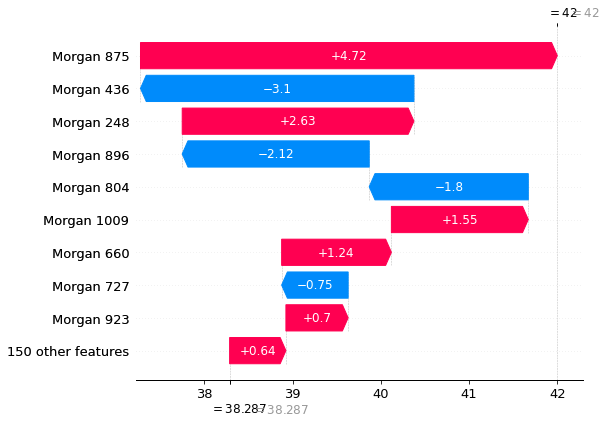

In [9]:
#单分子shap图 MORGAN

import shap
model1 = joblib.load(filename="RF_cir.model")
model2 = joblib.load(filename="svm_des.model")
df1 = pd.read_csv('circular_fingerprint_selected.csv')
df2 = pd.read_csv('descriptors_train.csv')
explainer_rf = shap.TreeExplainer(model1)
explainer_svm = shap.KernelExplainer(model2.predict,df2)

def single_mor(nmb):
    import matplotlib.pyplot as plt
    shap_valuessss = explainer_rf.shap_values(df1.iloc[nmb])
    # shap.force_plot(explainer_rf.expected_value, shap_valuessss, df2.iloc[2])
    # shap.plots.waterfall(shap_valuessss)
    shap.plots._waterfall.waterfall_legacy(explainer_rf.expected_value[0], shap_valuessss, df1.iloc[nmb], show=False)
    plt.savefig(('./vis_img/%i/shap.png' %nmb),dpi = 600,bbox_inches = 'tight')

def single_des(nmb):
    import matplotlib.pyplot as plt
    shap_values = explainer_rf(df1)
    shap_values2 = explainer_rf(df2)
    shap_valuessss = explainer_rf.shap_values(df2.iloc[nmb])
    # shap.force_plot(explainer_rf.expected_value, shap_valuessss, df2.iloc[2])
    # shap.plots.waterfall(shap_valuessss)
    # shap.plots._waterfall.waterfall_legacy(explainer_rf.expected_value[0], shap_valuessss, df2.iloc[nmb])
    shap.plots._waterfall.waterfall_legacy(explainer_svm.expected_value, shap_valuessss, df2.iloc[nmb], show=False)
    plt.savefig(('./vis_img/%i/shap2.png' %nmb),dpi = 600,bbox_inches = 'tight')

import matplotlib.pyplot as plt
single_mor(8)
# single_des(35)

In [1]:
from ipywidgets import interact, fixed, IntSlider

def renderFpBit(mol,bitIdx,bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol,bid,bitInfo)))
def select(nmb):
    interact(renderFpBit, bitIdx=list(bit_info_train[nmb].keys()),mol=fixed(mols_train[nmb]),
             bitInfo=fixed(bit_info_train[nmb]),fn=fixed(Draw.DrawMorganBit));
select(8)


NameError: name 'bit_info_train' is not defined